# Housekeeping

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Variables, Gathering Data and Creating MACD

In [26]:
TICKER = 'SPY'
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9
LOOKBACK = 365

def get_data(ticker=TICKER):
    df = yf.download(ticker)
    df = yf.download(ticker, period = 'max')
    df.columns = df.columns.get_level_values(0)

    # only return the subset of data you are interested in
    return df.iloc[-LOOKBACK:, :]


def add_MACD(df, fast=MACD_FAST, slow=MACD_SLOW, span=MACD_SPAN):
    df[f'{fast}_ema'] = df['Close'].ewm(span=fast).mean()
    df[f'{slow}_ema'] = df['Close'].ewm(span=slow).mean()

    df['MACD'] = df[f'{fast}_ema'] - df[f'{slow}_ema'] # The MACD line is the difference between the fast and slow 

    df['Signal'] = df['MACD'].ewm(span=span).mean()  #MACD signal is a 9 period moving average of the MACD line

    df['MACD_Hist'] = df['MACD'] - df['Signal'] #Histogram Values

    plt.figure(figsize=(12, 6))
    plt.bar(x=range(len(df)), height=df['MACD_Hist'], label='MACD Histogram', color='navy', alpha=1)
    plt.title(f'{MACD_FAST}-{MACD_SLOW}-{MACD_SPAN} MACD Histogram')
    plt.xlabel('Number of Days')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return df

# Creating and Testing the Strategy

In [27]:
def add_strategy(df):
    df['Strategy'] = 0

    
    df['Strategy'] = np.where(df['MACD_Hist'] > 0, 1, -1)
    df['Strategy'] = df['Strategy'].shift(1)
    return df

def test_strategy(df):
    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() - 1

    subset = df.iloc[-LOOKBACK:, :]
    
    plt.figure(figsize=(12, 6))
    plt.plot(subset['Asset_Returns'], label=f'{TICKER} Cumulative Returns', color = 'red')
    plt.plot(subset['Strategy_Returns'], label = f' {TICKER} MACD Strategy Returns', color = 'navy')
    plt.legend()
    plt.title(f'{TICKER} MACD Strategy')
    plt.axhline(0, color='black', linewidth=1, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    return df

# Performance Metrics and Running the Code

C:\Users\edwar\AppData\Local\Temp\ipykernel_18016\639923735.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker)
[*********************100%***********************]  1 of 1 completed
C:\Users\edwar\AppData\Local\Temp\ipykernel_18016\639923735.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period = 'max')
[*********************100%***********************]  1 of 1 completed


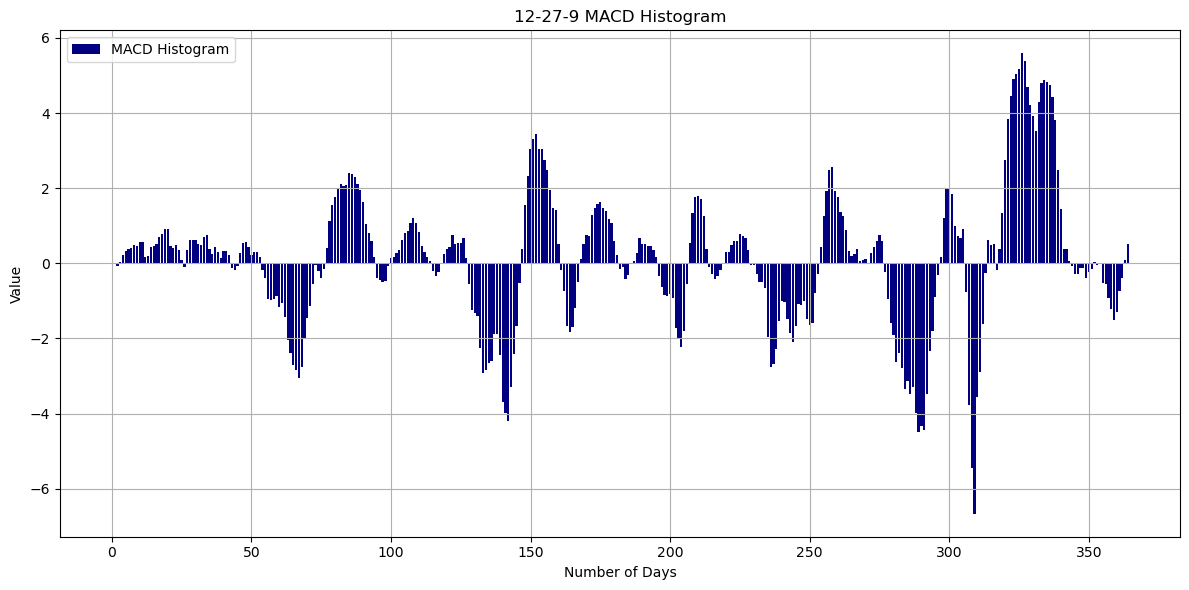

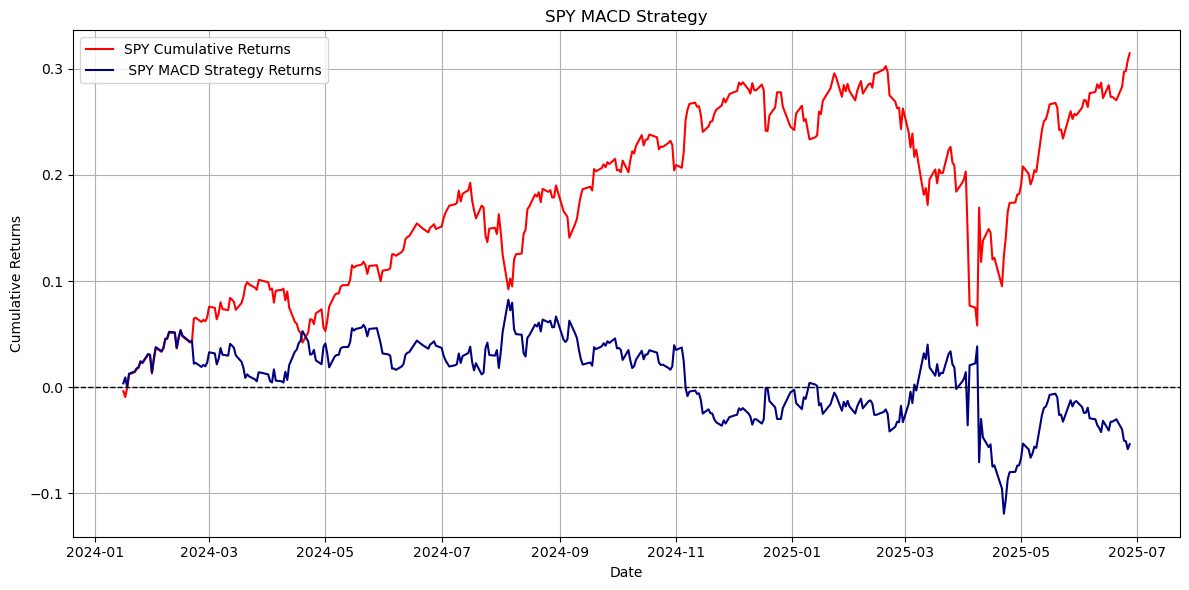

SPY Buy & Hold Return: 31.43%
SPY MACD Strategy Return over past 365 days: -5.36%


In [28]:
def return_summary(df, ticker, window):
    asset_return = df['Asset_Returns'].iloc[-1] * 100
    strategy_return = df['Strategy_Returns'].iloc[-1] * 100
    print(f"{TICKER} Buy & Hold Return: {asset_return:.2f}%")
    print(f"{TICKER} MACD Strategy Return over past {LOOKBACK} days: {strategy_return:.2f}%")

def main():
    df = get_data()
    df = add_MACD(df)
    df = add_strategy(df)
    df = test_strategy(df)
    return_summary(df, TICKER, LOOKBACK)
    return df

df = main()